In [17]:
import json
from abc import ABC, abstractmethod
import numpy as np
from termcolor import colored
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors

from typing import Optional
from itertools import product, islice, permutations, chain

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, pipeline
from peft import LoraConfig, PeftModel, prepare_model_for_kbit_training
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM
from datasets import Dataset
import os
import random

In [2]:
class cfg:
    model_path = "/teamspace/studios/this_studio/mtl_assignment2_4/saved_models/Qwen2.5-0.5B-Instruct"
    adapter_path =None
    train_dataset = "/teamspace/studios/this_studio/mtl_assignment2_4/data/arc_data/arc-agi_training_challenges.json"
    # train_dataset = '/mnt/hdd0/Kaggle/arc24/data/rearc/re_arc_100.json'
    val_dataset = "/teamspace/studios/this_studio/mtl_assignment2_4/data/arc_data/arc-agi_evaluation_challenges.json"
    output_dir = './'
    max_seq_len = 4096
    epochs = 50
    max_steps : Optional[int] =  100000# If given it will override epochs
    eval_steps = 100
    warmup_ratio = 0.1
    learning_rate = 5e-5
    # LoRA
    use_rslora = True,
    use_dora = True,
    lora_r = 32
    # data augmentation
    use_data_augmentation = True  #note that data augmentations have been set to false
    max_train_permutations = 2 # typically 2
    color_swaps = 1
    preserve_original_colors = False
    geometric_transforms = 2 # 0-8
    swap_train_and_test = True
    repeat_prompts = False # if bigger than 0 it will repeat the prompts that many times

In [3]:
if 'qwen' in cfg.model_path.lower():
    device_map = {
        'model.embed_tokens': 0,
        'lm_head': 0,
        'model.layers.0': 0,
        'model.layers.1': 0,
        'model.layers.2': 0,
        'model.layers.3': 0,
        'model.layers.4': 0,
        'model.layers.5': 0,
        'model.layers.6': 0,
        'model.layers.7': 0,
        'model.layers.8': 0,
        'model.layers.9': 0,
        'model.layers.10': 0,
        'model.layers.11': 0,
        'model.layers.12': 0,
        'model.layers.13': 0,
        'model.layers.14': 0,
        'model.layers.15': 0,
        'model.layers.16': 0,
        'model.layers.17': 0,
        'model.layers.18': 0,
        'model.layers.19': 0,
        'model.layers.20': 0,
        'model.layers.21': 0,
        'model.layers.22': 0,
        'model.layers.23': 0,
        'model.norm': 0,
        'model.rotary_emb': 0,
    }
else:
    device_map = 'balanced'

In [4]:

def get_flash_attention_implementation():
    try:
        import flash_attn
        attn_implementation = "flash_attention_2"
    except ImportError:
        attn_implementation = None
    return attn_implementation

#INSTANTIATE MODEL
model = AutoModelForCausalLM.from_pretrained(
    cfg.model_path,
    #quantization_config=bnb_config,
    device_map=device_map,
    # max_memory={0: '9GB', 1: '8GB'},
    trust_remote_code=True,
    torch_dtype=torch.bfloat16,
    attn_implementation=get_flash_attention_implementation(),
    )


In [5]:
def get_tokenizer(model_path, model, pad_token='<|pad|>'):
    tokenizer = AutoTokenizer.from_pretrained(
        model_path,
        trust_remote_code=True)
    if tokenizer.pad_token == tokenizer.eos_token:
        if 'qwen' in model_path.lower():
            tokenizer.eos_token = '<|im_end|>'
    elif 'pad_token' not in tokenizer.special_tokens_map or tokenizer.pad_token == tokenizer.eos_token:
        assert pad_token not in tokenizer.get_vocab()
        tokenizer.add_special_tokens({'pad_token': pad_token})
        tokenizer.padding_side = 'right'
        model.resize_token_embeddings(len(tokenizer))
    # if tokenizer.chat_template is None:
    #     logger.warning('The tokenizer does not have a chat template, assigning Qwen2 chat template')
    #     tokenizer.chat_template = AutoTokenizer.from_pretrained('Qwen/Qwen2.5-0.5B-Instruct', trust_remote_code=True).chat_template
    #     # tried adding this additional code without success
    #     tokenizer.add_special_tokens({'eos_token': '<|im_end|>'})
    #     tokenizer.add_special_tokens({'pad_token': '<|endoftext|>'})
    #     # tokenizer.eos_token = '<|im_end|>'
    #     # tokenizer.pad_token = '<|endoftext|>'
    assert tokenizer.pad_token != tokenizer.eos_token
    assert tokenizer.pad_token_id != tokenizer.eos_token_id
    return tokenizer

tokenizer = get_tokenizer(cfg.model_path, model)

In [6]:
def load_arc_data_with_solutions(filepath):
    with open(filepath, 'r') as f:
        data = json.load(f)
    solutions_filepath = filepath.replace('challenges.json', 'solutions.json')
    if filepath != solutions_filepath and os.path.exists(solutions_filepath):
        with open(solutions_filepath, 'r') as f:
            solutions = json.load(f)
        for sample_id, task in data.items():
            for idx, sample in enumerate(task['test']):
                sample['output'] = solutions[sample_id][idx]
    else:
        print('No solutions file found, the solutions should already be in the data')
    return data

In [7]:
class GridEncoder(ABC):
    @abstractmethod
    def to_text(self, grid):
        pass
    
    @abstractmethod
    def to_grid(self, text):
        pass

In [8]:
class MinimalGridEncoder(GridEncoder):
    @staticmethod
    def to_text(grid):
        text = '\n'.join([''.join([str(x) for x in line]) for line in grid])
        return text
    
    @staticmethod
    def to_grid(text):
        lines = text.strip().splitlines()
        grid = [[int(x) for x in line] for line in lines]
        return grid
        


In [9]:
class GridWithSeparationEncoder(GridEncoder):
    def __init__(self, split_symbol):
        self.split_symbol = split_symbol

    def to_text(self, grid):
        text = '\n'.join([self.split_symbol.join([str(x) for x in line]) for line in grid])
        return text

    def to_grid(self, text):
        lines = text.strip().splitlines()
        grid = [[int(x) for x in line.split(self.split_symbol)] for line in lines]
        return grid


In [10]:
class GridCodeBlockEncoder(GridEncoder):
    def __init__(self, base_encoder):
        self.encoder = base_encoder

    def to_text(self, grid):
        text = f'```grid\n{self.encoder.to_text(grid)}\n```'
        return text

    def to_grid(self, text):
        grid_text = text.split('```grid\n')[1].split('\n```')[0]
        grid = self.encoder.to_grid(grid_text)
        return grid

In [11]:
class DataAugmentation():
    def __init__(self, flip, n_rot90):
        self.flip = flip
        self.n_rot90 = n_rot90

    def augment_task(self, task):
        augmented_task = dict()
        for partition, samples in task.items():
            augmented_task[partition] = [{name:self.augment_grid(grid) for name,grid in sample.items()} for sample in samples]
        return augmented_task

    def augment_grid(self, grid):
        grid = np.array(grid)
        if self.flip:
            grid = np.flip(grid, axis=1)
        grid = np.rot90(grid, k=self.n_rot90)
        return grid.tolist()

    def revert_augmentation(self, grid):
        grid = np.array(grid)
        grid = np.rot90(grid, k=-self.n_rot90)
        if self.flip:
            grid = np.flip(grid, axis=1)
        return grid.tolist()

In [12]:
#PLOT

def plot_grid(grid):
    grid = np.array(grid)
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    plt.imshow(grid, cmap=cmap, norm=norm)
    plt.grid(True,which='both',color='lightgrey', linewidth=0.5)
    plt.xticks(np.arange(-0.5, grid.shape[1]), [])
    plt.yticks(np.arange(-0.5, grid.shape[0]), [])
    plt.xlim(-0.5, grid.shape[1]-0.5)

    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            plt.text(j, i, grid[i, j], ha='center', va='center')
def plot_task(task):
    all_samples = task['train'] + task['test']
    for plot_idx, sample in enumerate(all_samples):
        plt.subplot(1, len(all_samples), plot_idx+1)
        plot_grid(sample['input'])
        if plot_idx < len(task['train']):
            plt.title(f'train {plot_idx}')
        else:
            plt.title(f'test {plot_idx-len(task["train"])}')
    plt.suptitle('Inputs for task')
    plt.show()
    for plot_idx, sample in enumerate(all_samples):
        plt.subplot(1, len(all_samples), plot_idx+1)
        plot_grid(sample['output'])
        if plot_idx < len(task['train']):
            plt.title(f'train {plot_idx}')
        else:
            plt.title(f'test {plot_idx-len(task["train"])}')
    plt.suptitle('Outputs for task')
    plt.show()

In [13]:
def swap_one_train_and_test_sample(task):
    augmented_tasks = [task]
    for train_idx, train_sample in enumerate(task['train']):
        for test_idx, test_sample in enumerate(task['test']):
            augmented_task = dict()
            augmented_task['train'] = task['train'][:train_idx] + [test_sample] + task['train'][train_idx+1:]
            augmented_task['test'] = task['test'][:test_idx] + [train_sample] + task['test'][test_idx+1:]
            augmented_tasks.append(augmented_task)
    return augmented_tasks


def swap_task_colors(task, change_background_probability=0.1):
    colors = list(range(10))
    if random.random() < change_background_probability:
        new_colors = list(range(10))
        random.shuffle(new_colors)
    else:
        new_colors = list(range(1, 10))
        random.shuffle(new_colors)
        new_colors = [0] + new_colors

    color_map = {x: y for x, y in zip(colors, new_colors)}
    vectorized_mapping = np.vectorize(color_map.get)

    new_task = dict()
    for key in task.keys():
        new_task[key] = [{name:vectorized_mapping(grid) for name, grid in sample.items()} for sample in task[key]]
    return new_task


def permute_train_samples(task, max_permutations=6):
    augmented_tasks = []
    for _ in range(max_permutations):
        train_order = np.arange(len(task['train']))
        np.random.shuffle(train_order)
        augmented_task = dict()
        augmented_task['train'] = [task['train'][idx] for idx in train_order]
        augmented_task['test'] = task['test']
        augmented_tasks.append(augmented_task)
    return augmented_tasks


def apply_geometric_augmentations(task, n_augmentations=8):
    augmented_tasks = []
    data_augmentation_params = product([False, True], [0, 1, 2, 3])
    if n_augmentations < 8:
        data_augmentation_params = list(data_augmentation_params)
        indices = np.random.choice(np.arange(len(data_augmentation_params)), n_augmentations, replace=False)
        data_augmentation_params = [data_augmentation_params[idx] for idx in indices]
    for flip, n_rot90 in data_augmentation_params:
        data_augmentation = DataAugmentation(flip, n_rot90)
        augmented_task = data_augmentation.augment_task(task)
        augmented_tasks.append(augmented_task)
    return augmented_tasks
def apply_all_data_augmentations(tasks):
    print('Applying all data augmentations, initial number of tasks is', len(tasks))
    augmented_tasks = tasks
    if cfg.geometric_transforms:
        augmented_tasks = list(chain(*[apply_geometric_augmentations(task, cfg.geometric_transforms) for task in tqdm(augmented_tasks, desc='geometric augmentations')]))
        print(f'After applying geometric augmentations there are {len(augmented_tasks)} tasks')
    if cfg.swap_train_and_test:
        augmented_tasks = list(chain(*[swap_one_train_and_test_sample(task) for task in tqdm(augmented_tasks, desc='swap train and test')]))
        print(f'After swapping train and test samples there are {len(augmented_tasks)} tasks')
    if cfg.max_train_permutations:
        augmented_tasks = list(chain(*[permute_train_samples(task, max_permutations=cfg.max_train_permutations) for task in tqdm(augmented_tasks, desc='permute train samples')]))
        print(f'After permuting train samples there are {len(augmented_tasks)} tasks')
    if cfg.color_swaps:
        if cfg.preserve_original_colors:
            augmented_tasks.extend([swap_task_colors(task) for task in tqdm(augmented_tasks*cfg.color_swaps, desc='swap colors')])
        else:
            augmented_tasks = [swap_task_colors(task) for task in tqdm(augmented_tasks*cfg.color_swaps, desc='swap colors')]
        print(f'After swapping colors there are {len(augmented_tasks)} tasks')
    return augmented_tasks

In [14]:
task_description = """You are a helpful AI assistant. Your job is to solve tasks from the Abstraction and Reasoning Challenge (ARC). 
The user will present you with sample input and output grids for each task. 
Your job will be to understand the transformation between the input and the output and apply it to the last input grid given by the user. 
The puzzle-like inputs and outputs present a grid where each square can be one of ten colors. A grid can be any height or width between 1x1 and 30x30.
The background of the grid is typically colored with 0.
The tasks from ARC are based on the following priors:

- Objectness: Objects persist and cannot appear or disappear without reason. Objects can interact or not depending on the circumstances.
- Goal-directed: Objects can be animate or inanimate. Some objects are "agents" - they have intentions and they pursue goals.
- Numbers & counting: Objects can be counted or sorted by their shape, appearance, or movement using basic mathematics like addition, subtraction, and comparison.
- Basic geometry & topology: Objects can be shapes like rectangles, triangles, and circles which can be mirrored, rotated, translated, deformed, combined, repeated, etc. Differences in distances can be detected.

The transformations between input and output should be based on these priors.
"""

def create_prompts_from_task(task, grid_encoder):
    prompts = []
    for test_sample in task['test']:
        messages = [{"role": "system", "content": task_description}]
        user_message = "Let's see if you can solve this simple ARC task. These are some input-output grid examples that define the task.\n"
        for example_idx, sample in enumerate(task['train']):
            user_message += f"\n## Example {example_idx}\n\n### Input\n\n{grid_encoder.to_text(sample['input'])}\n"
            user_message += f"### Output\n\n{grid_encoder.to_text(sample['output'])}\n"
        user_message += f"\n## Test case\n\n### Input\n\n{grid_encoder.to_text(test_sample['input'])}\n"
        messages.append({"role": "user", "content": user_message})
        messages.append({"role": "assistant", "content": f"### Output\n\n{grid_encoder.to_text(test_sample['output'])}\n"})

        prompt = tokenizer.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=False)
        prompts.append(prompt)
    return prompts

In [18]:
def create_dataset(filepath, grid_encoder, use_data_augmentation=True, repeat_prompts=0):
    data = load_arc_data_with_solutions(filepath)

    tasks = list(data.values())
    if use_data_augmentation:
        tasks = apply_all_data_augmentations(tasks)

    prompts = []
    for task in tqdm(tasks, desc='create prompts'):
        prompts.extend(create_prompts_from_task(task, grid_encoder))
    print(len(prompts))

    np.random.shuffle(prompts)
    pretty_print_prompt(prompts[0])

    prompt_lengths = [len(tokenizer.encode(prompt)) for prompt in tqdm(prompts, desc='Calculating prompt lengths')]
    plt.hist(prompt_lengths, bins=100);
    plt.title('Prompt length distribution')
    plt.xlabel('Number of tokens');
    plt.show()

    prompts = [prompt for prompt, prompt_length in zip(prompts, prompt_lengths) if prompt_length < cfg.max_seq_len]
    print(f'Leaving {len(prompts)} prompts after removing those longer than {cfg.max_seq_len} tokens')

    if repeat_prompts:
        repeated_prompts = prompts.copy()
        for _ in range(repeat_prompts):
            repeated_prompts = repeated_prompts.copy()
            np.random.shuffle(repeated_prompts)
            prompts.extend(repeated_prompts)
        print(f'Repeating prompts {repeat_prompts} times, now there are {len(prompts)} prompts')

    dataset = Dataset.from_dict({'text': prompts})
    return dataset

def pretty_print_prompt(text, default_color='black'):
    color = default_color
    attrs = None
    print('-'*80)
    for line in text.splitlines():
        if line.startswith('<|assistant|>') or line.startswith('<|im_start|>assistant'):
            color = 'blue'
        elif line.startswith('<|user|>') or line.startswith('<|im_start|>user'):
            color = default_color
        elif line.startswith('<|system|>') or line.startswith('<|im_start|>system'):
            color = 'green'
        if line.startswith('<'):
            attrs = ['bold']
        else:
            attrs = None
        print(colored(line, color, attrs=attrs))
    print('-'*80)

Applying all data augmentations, initial number of tasks is 400


geometric augmentations:   0%|          | 0/400 [00:00<?, ?it/s]

After applying geometric augmentations there are 800 tasks


swap train and test:   0%|          | 0/800 [00:00<?, ?it/s]

After swapping train and test samples there are 3584 tasks


permute train samples:   0%|          | 0/3584 [00:00<?, ?it/s]

After permuting train samples there are 7168 tasks


swap colors:   0%|          | 0/7168 [00:00<?, ?it/s]

After swapping colors there are 7168 tasks


create prompts:   0%|          | 0/7168 [00:00<?, ?it/s]

8072
--------------------------------------------------------------------------------
<|im_start|>system
You are a helpful AI assistant. Your job is to solve tasks from the Abstraction and Reasoning Challenge (ARC). 
The user will present you with sample input and output grids for each task. 
Your job will be to understand the transformation between the input and the output and apply it to the last input grid given by the user. 
The puzzle-like inputs and outputs present a grid where each square can be one of ten colors. A grid can be any height or width between 1x1 and 30x30.
The background of the grid is typically colored with 0.
The tasks from ARC are based on the following priors:

- Objectness: Objects persist and cannot appear or disappear without reason. Objects can interact or not depending on the circumstances.
- Goal-directed: Objects can be animate or inanimate. Some objects are "agents" - they have intentions and they pursue goals.
- Numbers & counting: Objects can be count

Calculating prompt lengths:   0%|          | 0/8072 [00:00<?, ?it/s]

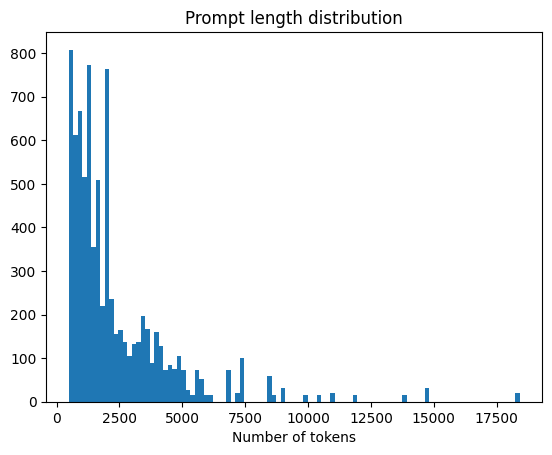

Leaving 6908 prompts after removing those longer than 4096 tokens


In [19]:
if 'qwen' in cfg.model_path.lower():
    # we need to add separation between numbers in the grid
    grid_encoder = GridCodeBlockEncoder(GridWithSeparationEncoder('|'))
else:
    grid_encoder = GridCodeBlockEncoder(MinimalGridEncoder())
    
train_dataset = create_dataset(
    cfg.train_dataset, grid_encoder,
    use_data_augmentation=cfg.use_data_augmentation,
    repeat_prompts=cfg.repeat_prompts)

create prompts:   0%|          | 0/400 [00:00<?, ?it/s]

419
--------------------------------------------------------------------------------
<|im_start|>system
You are a helpful AI assistant. Your job is to solve tasks from the Abstraction and Reasoning Challenge (ARC). 
The user will present you with sample input and output grids for each task. 
Your job will be to understand the transformation between the input and the output and apply it to the last input grid given by the user. 
The puzzle-like inputs and outputs present a grid where each square can be one of ten colors. A grid can be any height or width between 1x1 and 30x30.
The background of the grid is typically colored with 0.
The tasks from ARC are based on the following priors:

- Objectness: Objects persist and cannot appear or disappear without reason. Objects can interact or not depending on the circumstances.
- Goal-directed: Objects can be animate or inanimate. Some objects are "agents" - they have intentions and they pursue goals.
- Numbers & counting: Objects can be counte

Calculating prompt lengths:   0%|          | 0/419 [00:00<?, ?it/s]

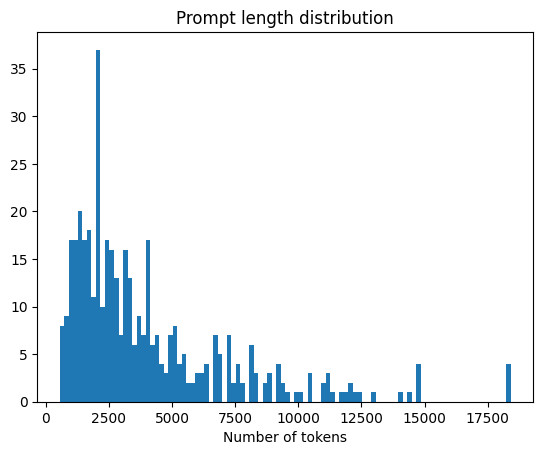

Leaving 284 prompts after removing those longer than 4096 tokens


In [20]:
val_dataset = create_dataset(cfg.val_dataset, grid_encoder, use_data_augmentation=False)

In [21]:
if cfg.adapter_path is None:
    peft_config = LoraConfig(
        # lora_alpha: LoRA scaling factor.
        lora_alpha=64, #64,
        lora_dropout=0.1, # 0.1, althought Vaca suggested to use 0.05 for big models
        # r: the rank of the update matrices, expressed in int. Lower rank results in smaller update matrices with fewer trainable parameters.
        r=cfg.lora_r, #16
        bias="none",
        task_type="CAUSAL_LM",
        # target_modules: The modules (for example, attention blocks) to apply the LoRA update matrices.
        target_modules= ['k_proj', 'q_proj', 'v_proj', 'o_proj'],
        use_rslora=cfg.use_rslora,
        use_dora=cfg.use_dora,
    )
else:
    print(f'Loading adapter from {cfg.adapter_path}')
    peft_config = None
    model = PeftModel.from_pretrained(model, cfg.adapter_path, is_trainable=True)

In [22]:
if 'qwen' in cfg.model_path.lower():
    print("inside qwen")
    batch_size_kwargs = dict(
        per_device_train_batch_size=1, # 4-16 should be fine for lora.
        gradient_accumulation_steps=5,
        per_device_eval_batch_size=1,
    )
else:
    batch_size_kwargs = dict(
        per_device_train_batch_size=1, # 4-16 should be fine for lora.
        gradient_accumulation_steps=16,
        per_device_eval_batch_size=2,
    )

training_arguments = TrainingArguments(
        output_dir=cfg.output_dir,
        num_train_epochs=cfg.epochs,
        max_steps=cfg.max_steps,
        warmup_ratio=cfg.warmup_ratio,
        learning_rate=cfg.learning_rate,
        lr_scheduler_type="linear",
        optim="paged_adamw_8bit",

        do_eval=True,
        evaluation_strategy="steps",
        save_steps=cfg.eval_steps,
        logging_steps=10, #50,
        eval_steps=cfg.eval_steps,
        log_level="debug",

        **batch_size_kwargs
)

inside qwen


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [23]:
if 'qwen' in cfg.model_path.lower():
    data_collator = data_collator = DataCollatorForCompletionOnlyLM(
            tokenizer=tokenizer,
            instruction_template='<|im_start|>user',
            response_template='<|im_start|>assistant',
        )
else:
    data_collator = DataCollatorForCompletionOnlyLM(
        tokenizer=tokenizer,
        instruction_template='<|user|>',
        response_template='<|assistant|>'
    )

In [25]:
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=cfg.max_seq_len,
    data_collator=data_collator,
    args=training_arguments,
    # packing=True, # ValueError: You passed a `DataCollatorForCompletionOnlyLM` to the SFTTrainer. This is not compatible with the `packing` argument.
)
try:
    trainer.train()
except:
    torch.cuda.empty_cache()

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field, max_seq_length. Will not be supported from version '0.13.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
PyTorch: setting up devices
loading file vocab.json
loading file merges.txt
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/zeus/miniconda

Map:   0%|          | 0/6908 [00:00<?, ? examples/s]

Map:   0%|          | 0/284 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs
Currently training with a batch size of: 1
***** Running training *****
  Num examples = 6,908
  Num Epochs = 73
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 5
  Gradient Accumulation steps = 5
  Total optimization steps = 100,000
  Number of trainable parameters = 4,374,528
